In [4]:
from pprint import pprint
from elasticsearch import Elasticsearch

In [60]:
es = Elasticsearch('http://localhost:9200')
client_info = es.info()
print('Connected to Elasticsearch!')
pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'Hb6aErwaQCmhnl_0DbAbbA',
 'name': '250e5fef5db6',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2024-08-05T10:05:34.233336849Z',
             'build_flavor': 'default',
             'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '9.11.1',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.15.0'}}


In [73]:
count = es.count(index='cpu_example_template')
pprint(count.body)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'count': 1335}


In [74]:
response = es.search(
    index='cpu_example_template',
    body={
        "query": {
            "match_all": {}
        },
        "size": 1000
    },
)
hits = response.body['hits']['hits']

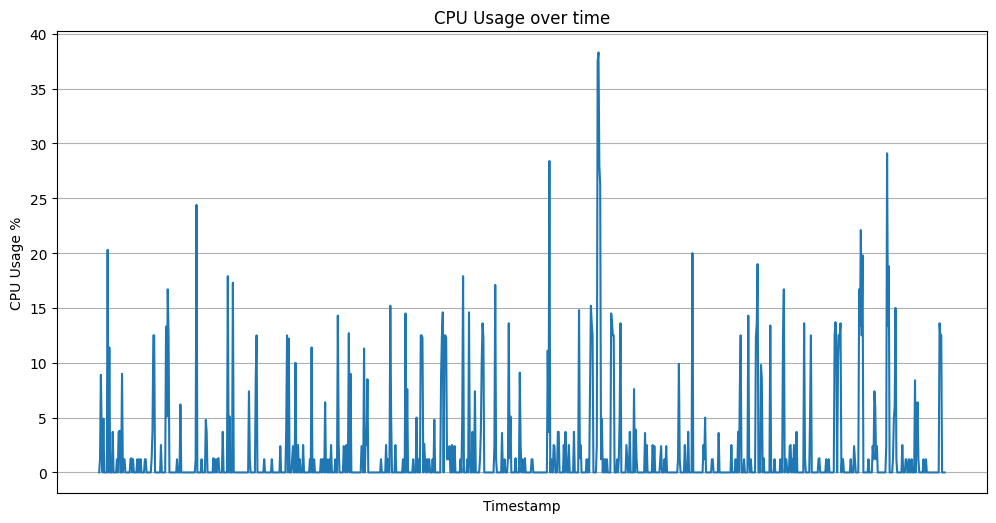

In [75]:
import matplotlib.pyplot as plt

cpu_usage_values = [hit['_source']['cpu_usage'] for hit in hits]
timestamp_values = [hit['_source']['@timestamp'] for hit in hits]

plt.figure(figsize=(12,6))
plt.plot(timestamp_values, cpu_usage_values)
plt.xticks([])
plt.xlabel('Timestamp')
plt.ylabel('CPU Usage %')
plt.title('CPU Usage over time')
plt.grid(True)
plt.show()

In [76]:
response = es.search(
    index='cpu_example_template',
    body={
        "aggs": {
            "avg_cpu_usage": {
                "avg": {
                    "field": "cpu_usage"
                }
            }
        },
    }
)

average_cpu_usage = response.body['aggregations']['avg_cpu_usage']['value']
print(average_cpu_usage)
# jakbysmy chcieli np. max usage to zamieniamy avg na max

2.621075591202392


In [77]:
response = es.indices.get_data_stream()
pprint(response.body)
# tu powinien byc wynik ile indeksow jest uruchomionych, ale chuj

{'data_streams': [{'_meta': {'description': 'Template for CPU usage data'},
                   'allow_custom_routing': False,
                   'generation': 1,
                   'hidden': False,
                   'ilm_policy': 'cpu_usage_policy_2',
                   'indices': [{'ilm_policy': 'cpu_usage_policy_2',
                                'index_name': '.ds-cpu_example_template-2025.02.15-000001',
                                'index_uuid': 'fKZSP8vNTJ-O-qlC2iLw9A',
                                'managed_by': 'Index Lifecycle Management',
                                'prefer_ilm': True}],
                   'name': 'cpu_example_template',
                   'next_generation_managed_by': 'Index Lifecycle Management',
                   'prefer_ilm': True,
                   'replicated': False,
                   'rollover_on_write': False,
                   'status': 'YELLOW',
                   'system': False,
                   'template': 'cpu_example_template',

In [78]:
print(es.info()['version']['number'])

8.15.0


In [79]:
ilm_status = es.ilm.get_lifecycle(name='cpu_usage_policy_2')
pprint(ilm_status.body)

{'cpu_usage_policy_2': {'in_use_by': {'composable_templates': ['cpu_usage_template_2',
                                                               'cpu_example_template'],
                                      'data_streams': ['cpu_example_template'],
                                      'indices': ['.ds-cpu_example_template-2025.02.15-000001']},
                        'modified_date': '2025-02-14T21:28:04.886Z',
                        'policy': {'phases': {'delete': {'actions': {'delete': {'delete_searchable_snapshot': True}},
                                                         'min_age': '20m'},
                                              'hot': {'actions': {'rollover': {'max_age': '5m'}},
                                                      'min_age': '0ms'}}},
                        'version': 1}}


In [80]:
response = es.ilm.explain_lifecycle(
    index=".ds-cpu_example_template-2025.02.15-000001")
pprint(response.body)
# teraz mozemy sie dowiedziec o cyklu zycia naszego indexu

{'indices': {'.ds-cpu_example_template-2025.02.15-000001': {'action': 'rollover',
                                                            'action_time_millis': 1739638016607,
                                                            'age': '3.44m',
                                                            'index': '.ds-cpu_example_template-2025.02.15-000001',
                                                            'index_creation_date_millis': 1739638016056,
                                                            'lifecycle_date_millis': 1739638016056,
                                                            'managed': True,
                                                            'phase': 'hot',
                                                            'phase_execution': {'modified_date_in_millis': 1739568484886,
                                                                                'phase_definition': {'actions': {'rollover': {'max_age': '5m',
       